In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import random

from scipy.io import loadmat
from matplotlib.ticker import MaxNLocator

In [2]:
# Define fonts and fontsize for plotting
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
fontsize = 15
fontsize_ticks = 12

In [3]:
# Define necessary functions
# Function to get displacement and void data
def get_data(file_directory):

    # Load the displacement data
    blind_test_displacement_data = loadmat(os.path.join(file_directory, 'blind_displacement_data.mat'))['displacement_data']

    # Load the void data
    blind_test_void_data = loadmat(os.path.join(file_directory, 'blind_void_data.mat'))['void_data']

    return blind_test_displacement_data, blind_test_void_data

In [4]:
# Function to normalize the displacement data
def normalize_data(data, mean, range):

    return (data - mean) / range

In [5]:
# Function to calculate metrics
def metrics_calculator(target, predicted):

    # True positive
    tp = 0

    # True negative
    tn = 0

    # False positive
    fp = 0

    # False negative
    fn = 0

    # Accuracy, Precision, Recall, F1 score
    accuracy = []
    precision = []
    recall = []

    for n_sample in range(target.shape[0]):

        for n_element in range(target.shape[1]):
            
            # If both the target and predicted are same
            if target[n_sample, n_element] == predicted[n_sample, n_element]:

                # If the target and predicted are both 1
                if target[n_sample, n_element] == 1 and predicted[n_sample, n_element] == 1:

                    tp = tp + 1

                # If the target and predicted are both 0
                elif target[n_sample, n_element] == 0 and predicted[n_sample, n_element] == 0:

                    tn = tn + 1
            
            # If the target and predicted are different
            else:

                # If the target is 0 and predicted is 1
                if target[n_sample, n_element] == 0 and predicted[n_sample, n_element] == 1:

                    fp = fp + 1
                
                # If the target is 1 and predicted is 0
                elif target[n_sample, n_element] == 1 and predicted[n_sample, n_element] == 0:
                
                    fn = fn + 1
            
        # Calculate accuracy, precision, and recall
        accuracy.append((tp + tn) / (tp + tn + fp + fn))
        precision.append(tp / (tp + fp))
        recall.append(tp / (tp + fn))
    
    # Convert the lists to numpy arrays
    accuracy = np.array(accuracy)
    precision = np.array(precision)
    recall = np.array(recall)

    # Calculate the F1 score
    f1_score = 2 * (precision * recall) / (precision + recall)

    return accuracy, precision, recall, f1_score

In [6]:
# Function to plot void 0 prediction
def plot_void(target, predicted, file_directory, f1_score):

    for sample_num in range(len(target)):

        # See how the actual void looks in target
        actual_plot = plt.figure()
        ax = plt.axes()
        im1 = plt.imshow(target[sample_num, :, :], cmap='binary', origin='lower', vmin=0, vmax=1, extent=[0, 50, 0, 50])
        
        # Domain section lines
        plt.axhline(y=10, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
        plt.axhline(y=20, color='k', linewidth = 0.5)
        plt.axhline(y=30, color='k', linewidth = 0.5)
        plt.axhline(y=40, color='k', linewidth = 0.5)

        plt.axvline(x=5, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
        plt.axvline(x=45, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
        
        plt.xlabel('$x$ [m]', fontsize=fontsize)
        plt.ylabel('$y$ [m]', fontsize=fontsize)
        plt.title(f'Sample Number: {sample_num+1}', fontsize=fontsize_ticks)
        ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
        cax = actual_plot.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        cb = plt.colorbar(im1, cax=cax)
        cb.ax.tick_params(labelsize=fontsize_ticks)
        plt.savefig(os.path.join(file_directory, f'sample_{sample_num+1}_void_target.pdf'), bbox_inches='tight')

        # See how the predicted void looks in prediction
        predicted_plot = plt.figure()
        ax = plt.axes()
        im2 = plt.imshow(predicted[sample_num, :], cmap='binary', origin='lower', vmin=0, vmax=1, extent=[0, 50, 0, 50])
        
        # Domain section lines
        plt.axhline(y=10, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
        plt.axhline(y=20, color='k', linewidth = 0.5)
        plt.axhline(y=30, color='k', linewidth = 0.5)
        plt.axhline(y=40, color='k', linewidth = 0.5)
        
        plt.axvline(x=5, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))
        plt.axvline(x=45, color='k', linewidth = 0.5, linestyle='--', dashes=(10, 5))

        plt.xlabel('$x$ [m]', fontsize=fontsize)
        plt.ylabel('$y$ [m]', fontsize=fontsize)
        plt.title(f'Sample Number: {sample_num+1}; F1 score: {f1_score[sample_num]*100:.2f}%', fontsize=fontsize_ticks)   
        ax.tick_params(axis='both', which='major', labelsize=fontsize_ticks)
        cax = predicted_plot.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
        cb = plt.colorbar(im2, cax=cax)
        cb.ax.tick_params(labelsize=fontsize_ticks)
        plt.savefig(os.path.join(file_directory, f'sample_{sample_num+1}_void_predicted.pdf'), bbox_inches='tight')

In [7]:
# Define directories
current_directory = os.getcwd()

# Define directory for the blind test data
blind_test_data_directory = os.path.join(current_directory, '..', '..', 'blind_data', 'assembled')

# Define directory for the normalizing parameters
normalized_data_directory = os.path.join(current_directory, '..', '..', 'data', 'normalized')

# Define directory for the trained model
trained_results_directory = os.path.join(current_directory, '..', '..', 'cnn', 'training_results')

# Define directory for the prediction results
prediction_results_directory = os.path.join(current_directory, '..', '..', 'cnn', 'prediction_results', 'blind_test')

In [8]:
# Load the blind test data
blind_displacement_data, blind_void_data = get_data(blind_test_data_directory)

In [9]:
# Load the normalizing parameters
normalizing_parameters = loadmat(os.path.join(normalized_data_directory, 'normalizing_parameters.mat'))

# Extract the normalizing parameters from the dictionary
normalizing_parameters = normalizing_parameters['values']

# Mean, min, and max values for normalizing the displacement data
mean = normalizing_parameters['mean'][0][0][0]
min_value = normalizing_parameters['min'][0][0][0]
max_value = normalizing_parameters['max'][0][0][0]

In [10]:
# Normalize the displacement data
blind_displacement_data = normalize_data(blind_displacement_data, mean, max_value - min_value)

In [11]:
# Load the trained model
# model = tf.keras.models.load_model(os.path.join(trained_results_directory, 'best_model.h5'))
model = tf.keras.models.load_model(os.path.join(trained_results_directory, 'model.h5'))

2024-11-16 17:56:17.310722: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-16 17:56:17.316587: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-16 17:56:17.316723: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:936] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-11-16 17:56:17.317219: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [12]:
# Use the model to predict on the test data both probability and class
threshold = 0.5
void_predicted_void_data_probabilistic = model.predict(blind_displacement_data)
void_predicted_void_data_class = np.where(void_predicted_void_data_probabilistic > threshold, 1, 0)

2024-11-16 17:56:18.925586: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8200
2024-11-16 17:56:19.202006: W tensorflow/stream_executor/gpu/asm_compiler.cc:111] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


In [13]:
# Plot the void prediction
# Calculate the metrics
accuracy, precision, recall, f1_score = metrics_calculator(blind_void_data, void_predicted_void_data_class)

/tmp/ipykernel_1020499/1894649521.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  actual_plot = plt.figure()


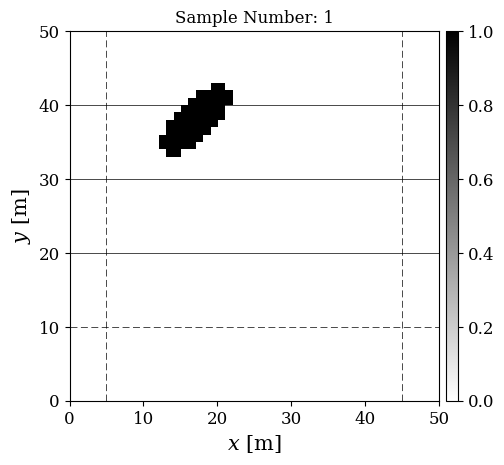

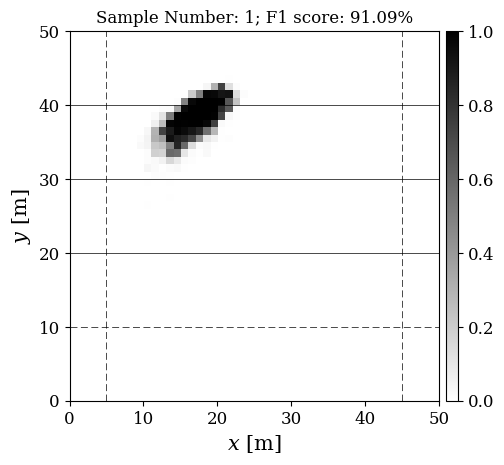

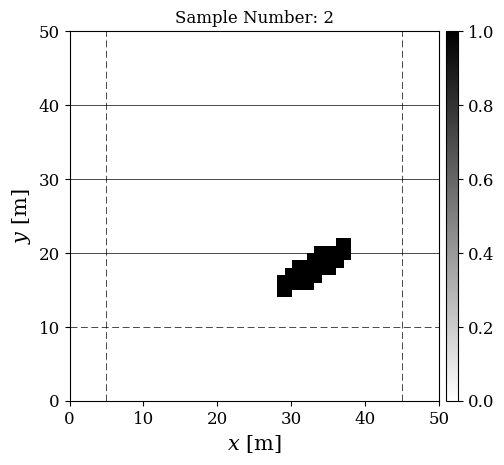

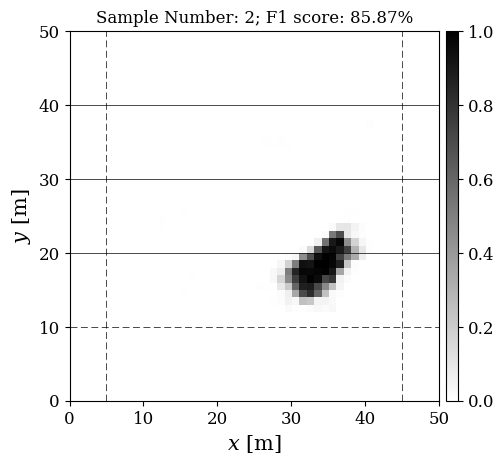

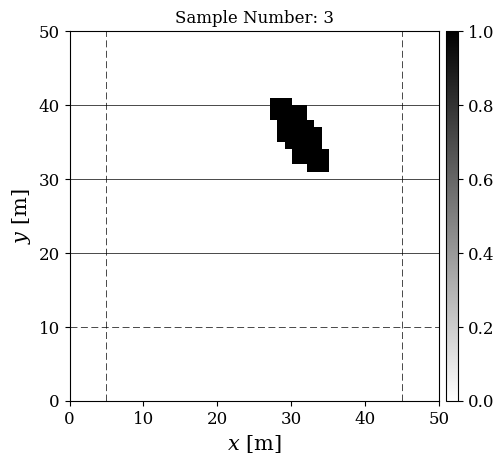

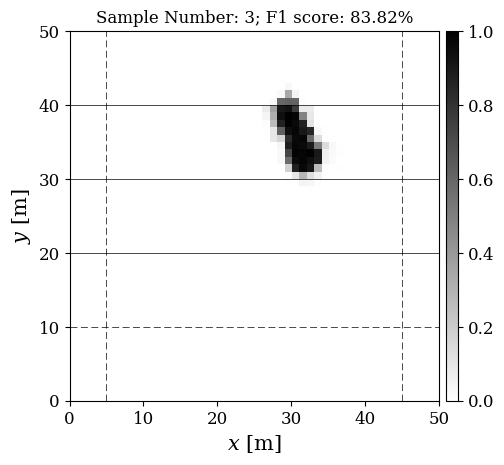

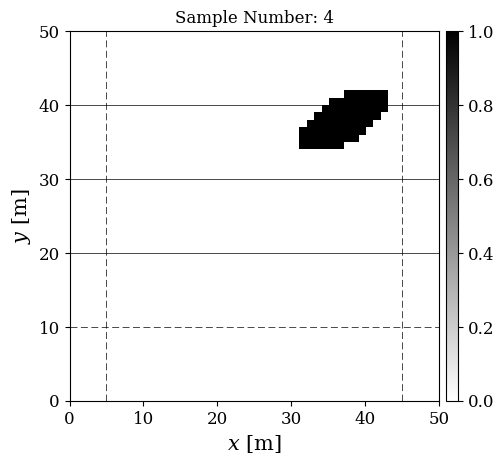

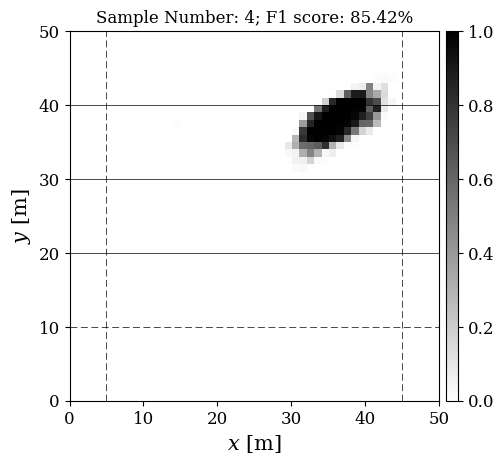

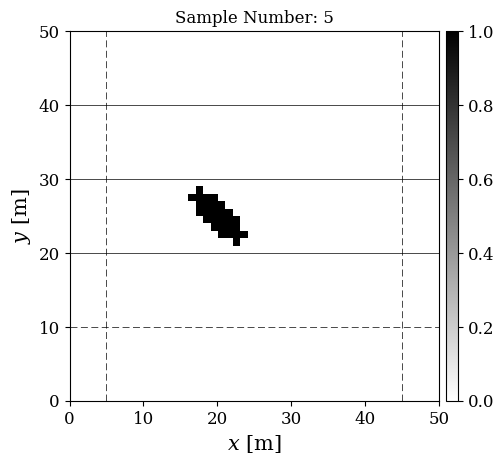

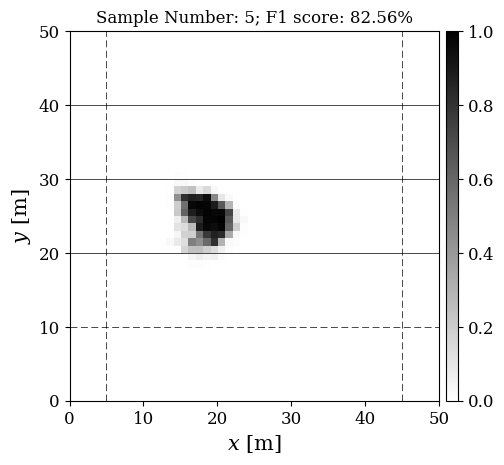

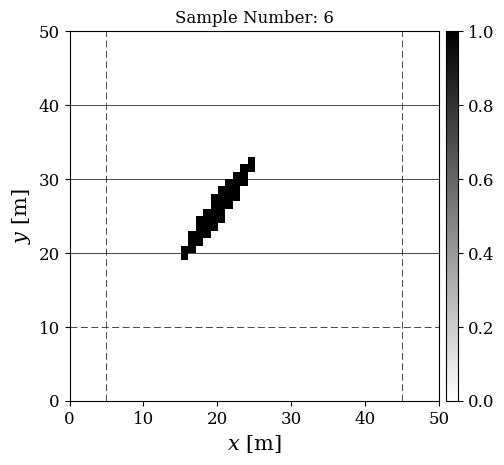

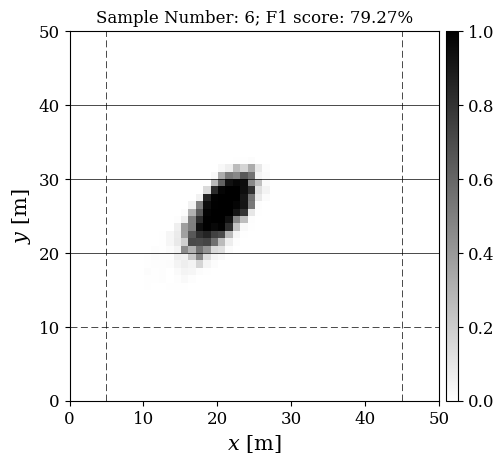

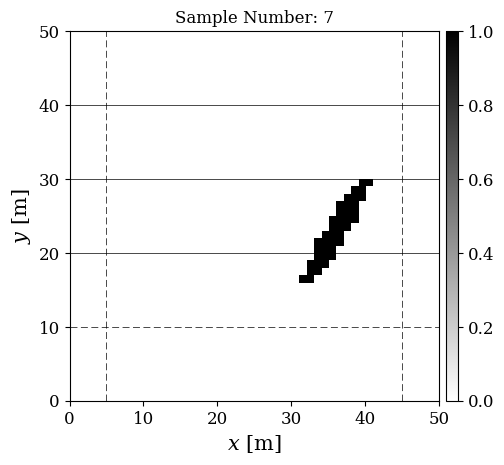

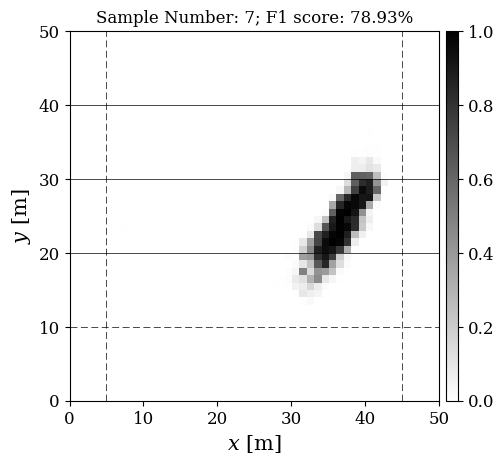

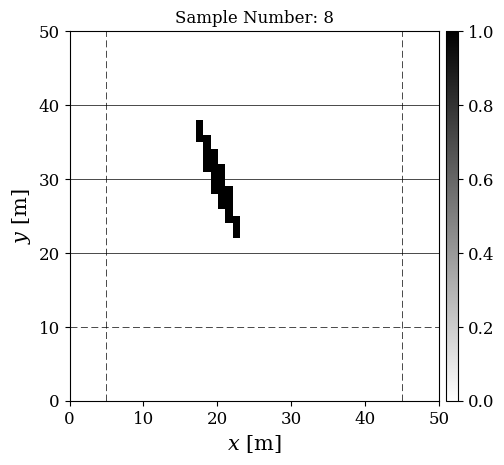

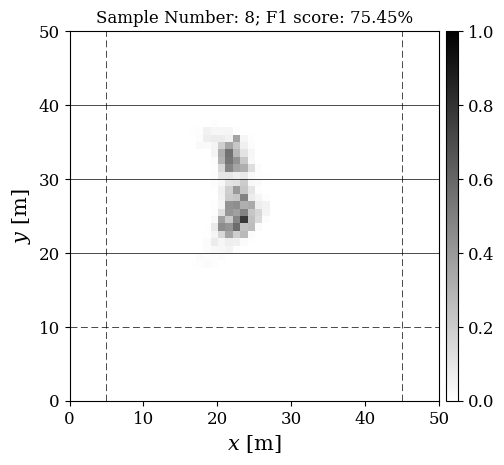

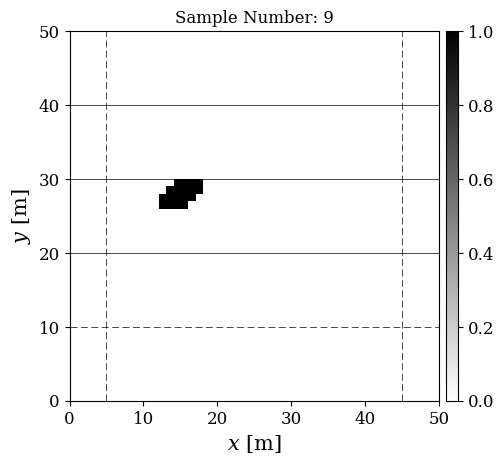

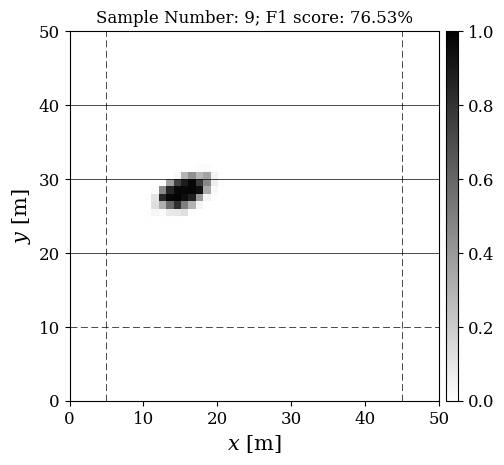

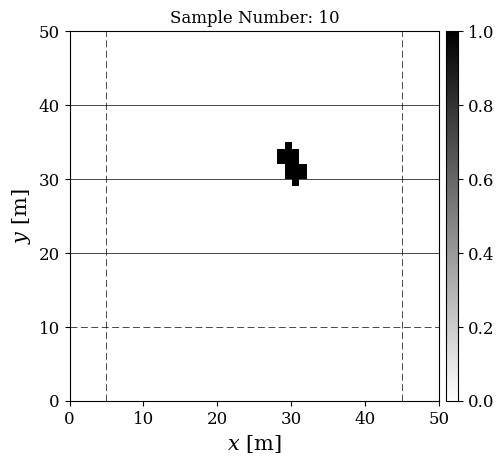

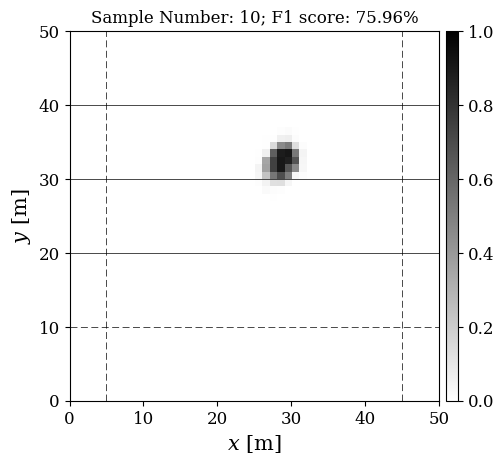

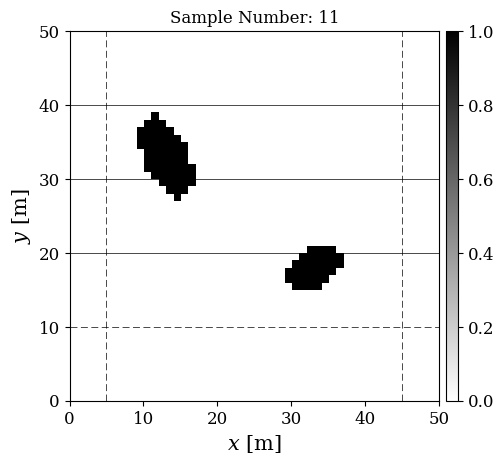

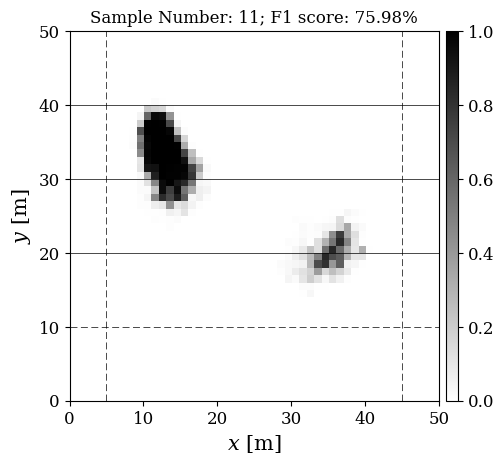

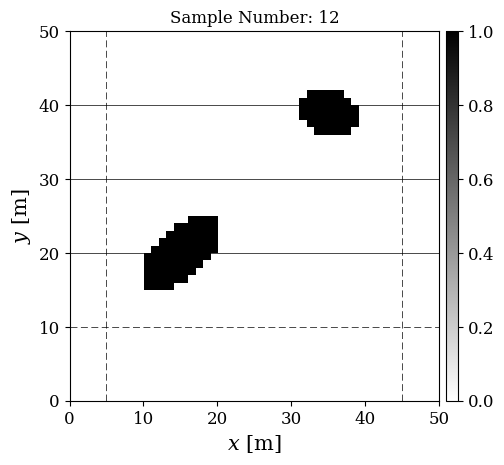

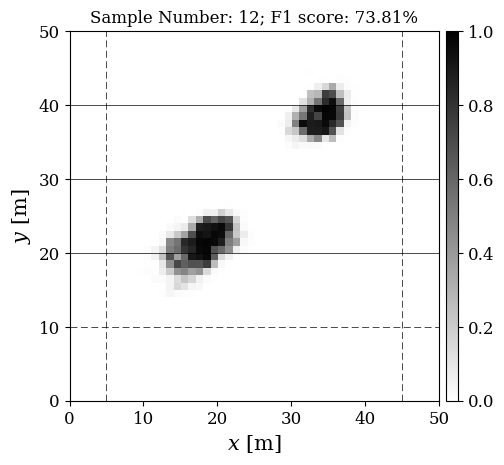

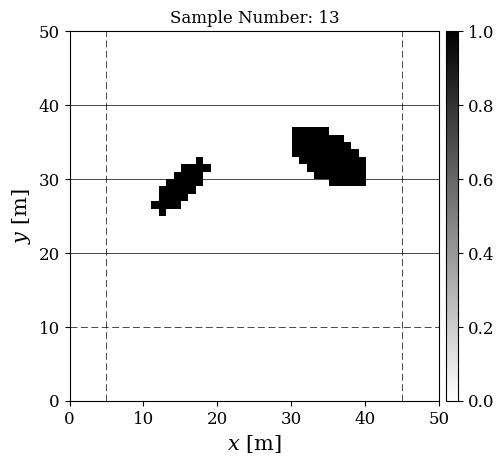

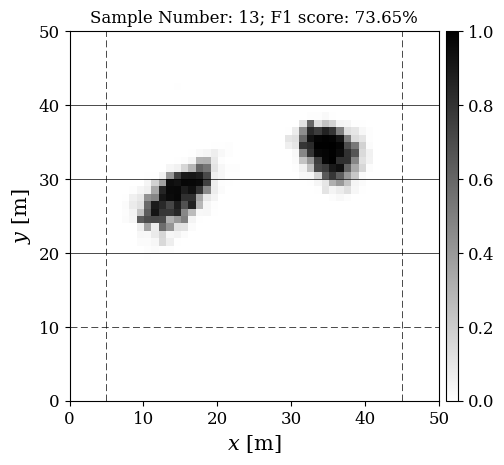

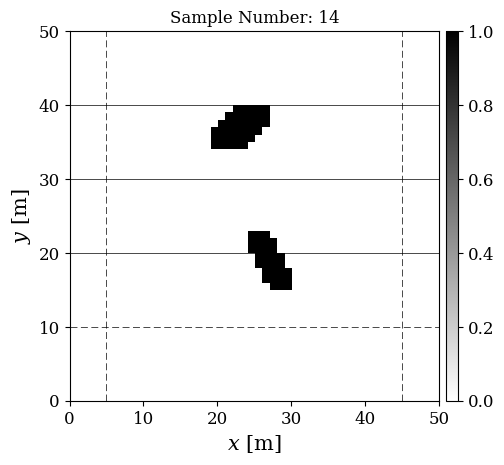

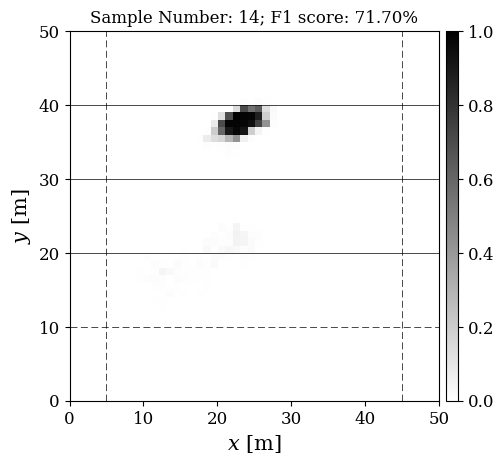

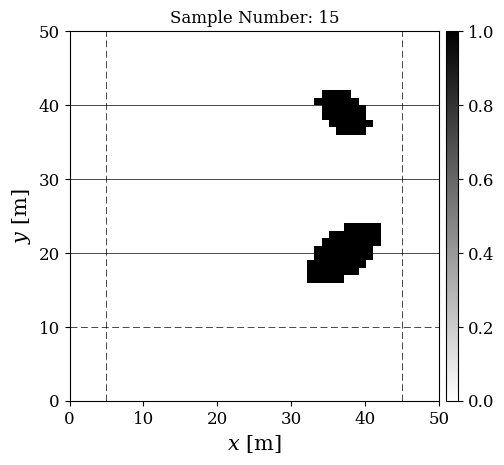

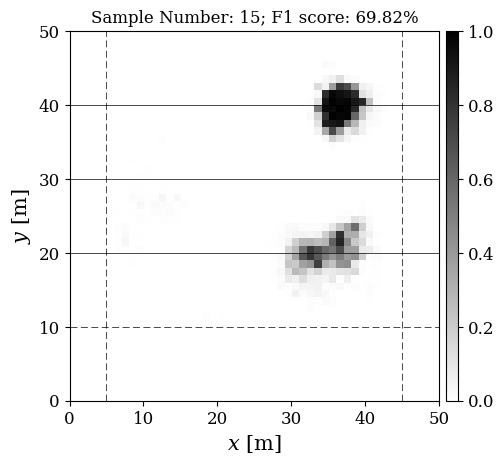

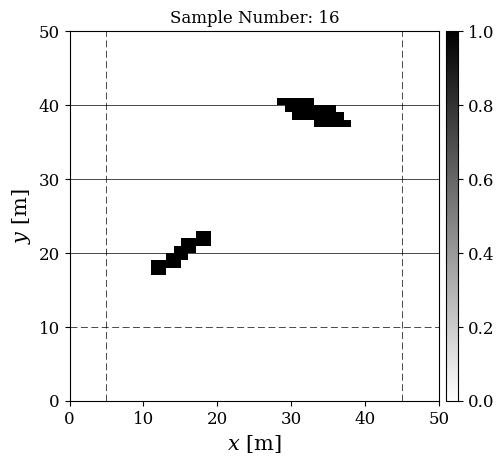

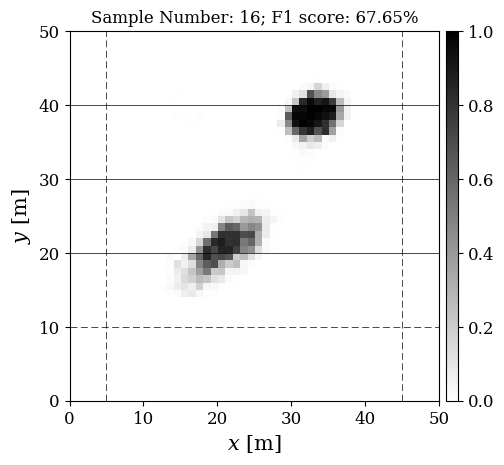

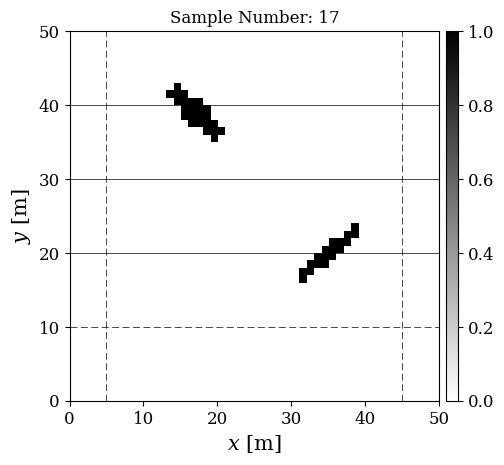

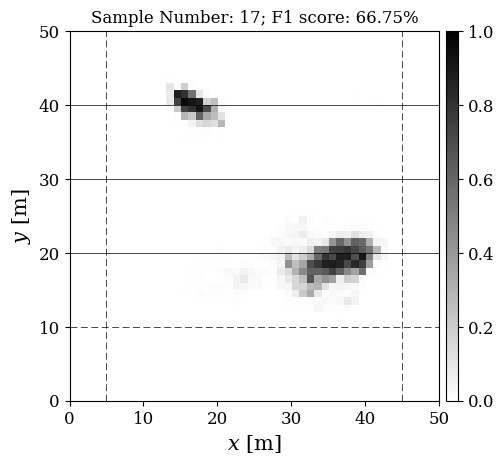

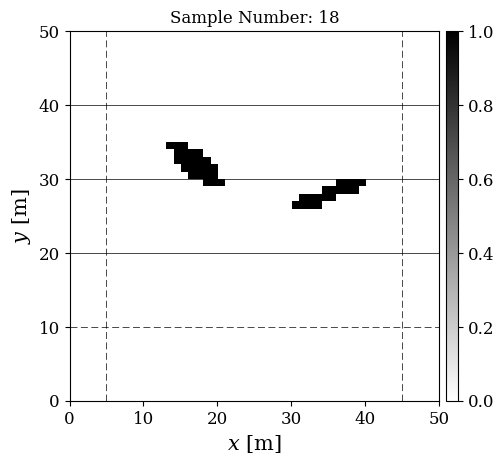

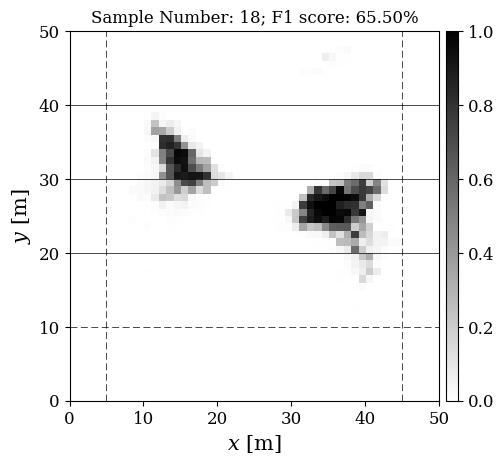

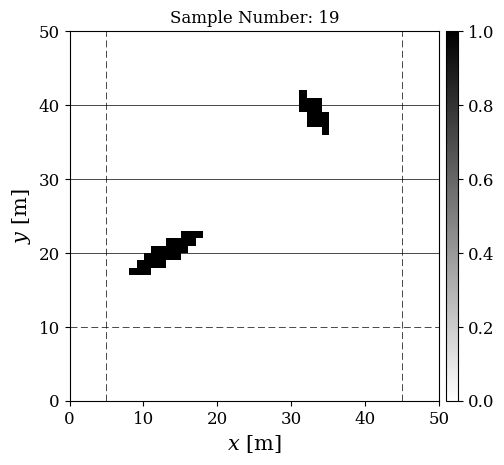

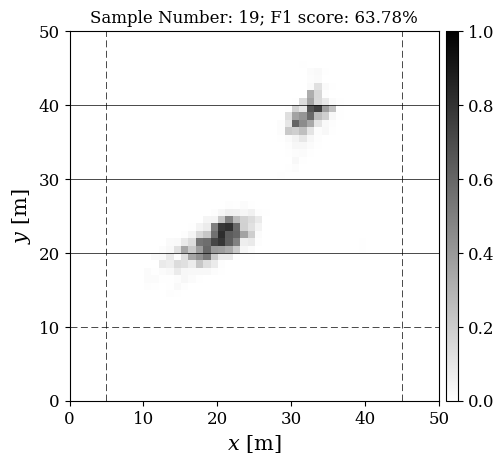

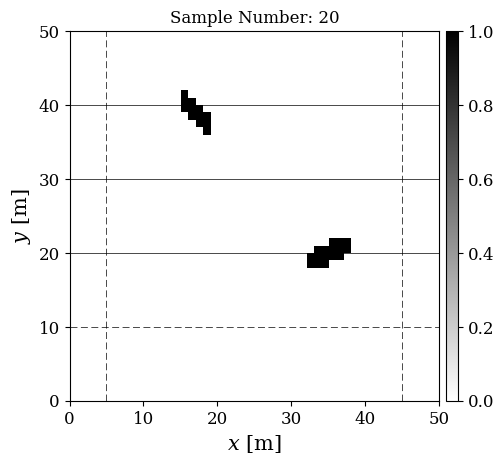

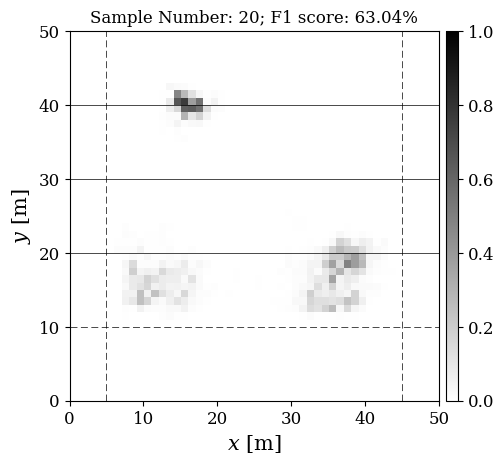

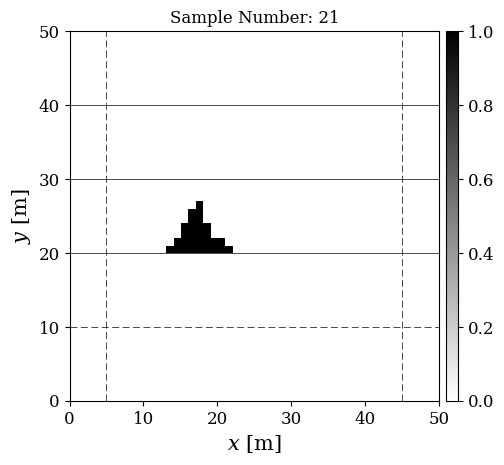

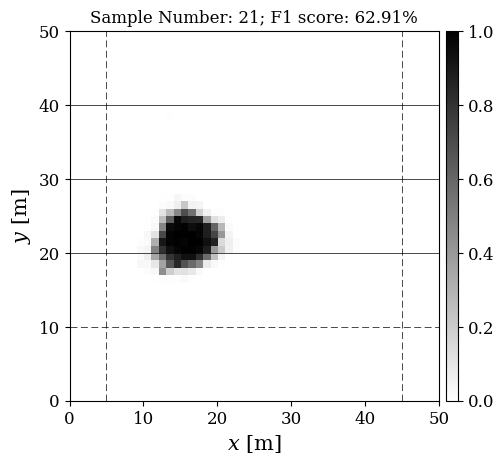

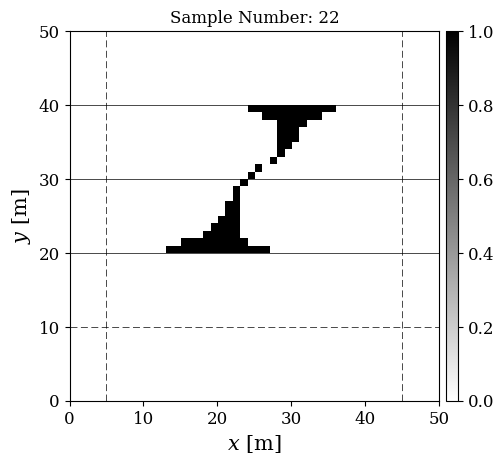

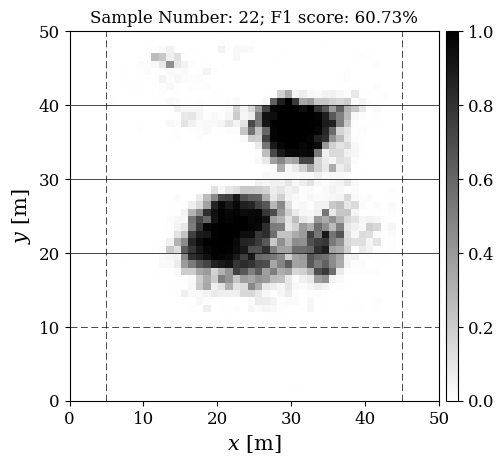

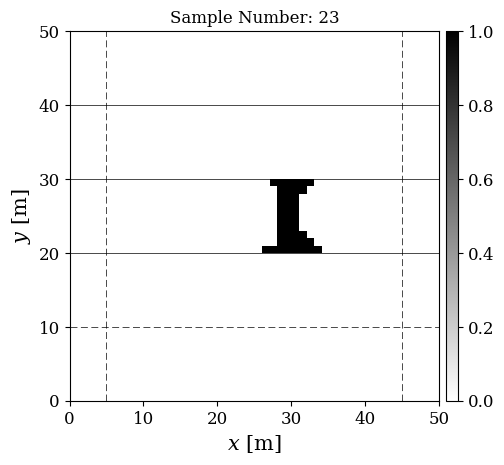

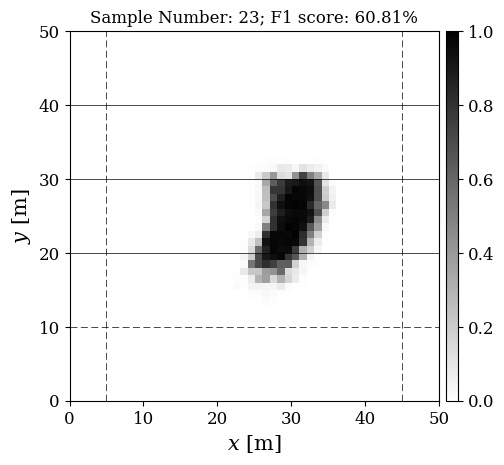

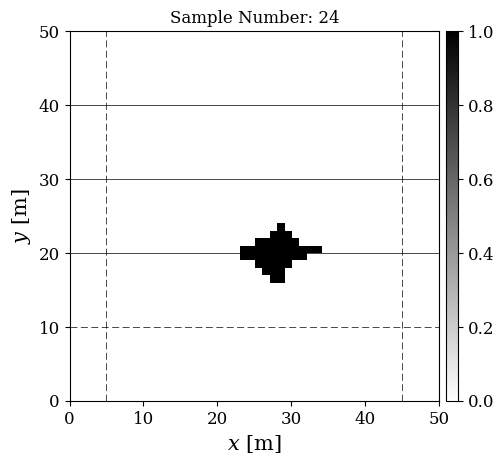

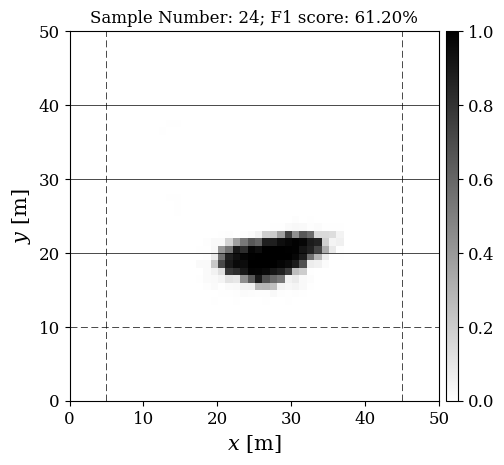

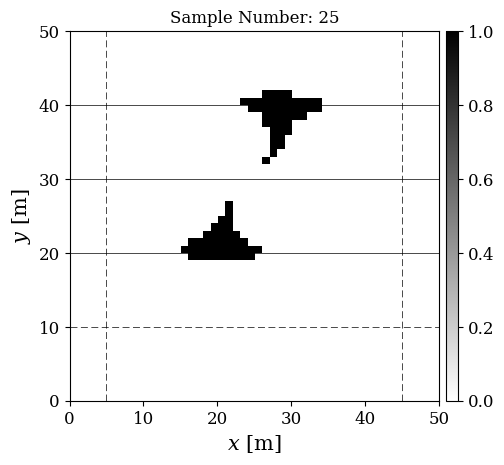

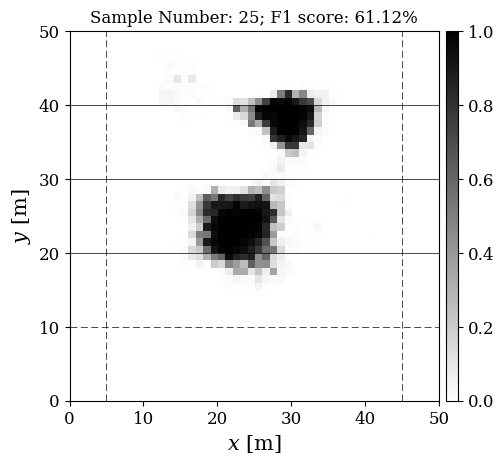

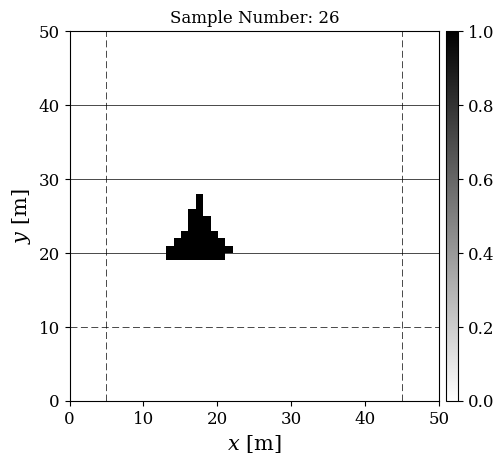

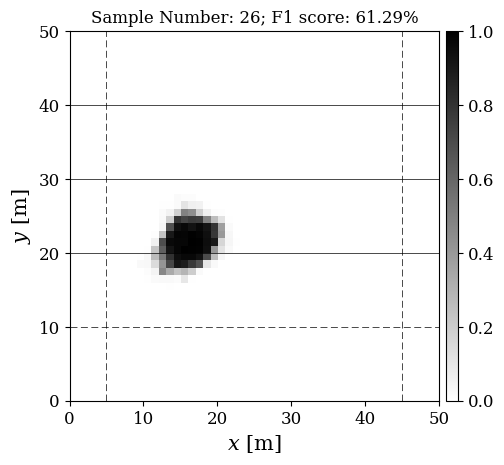

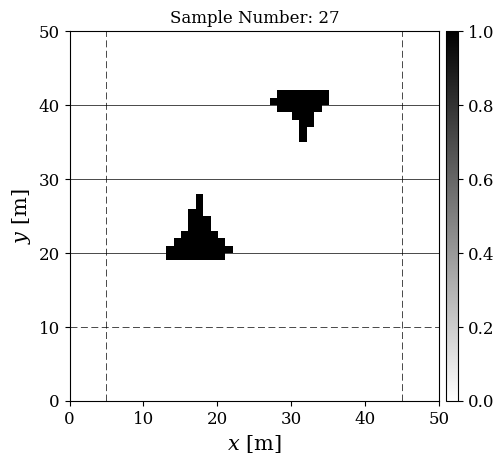

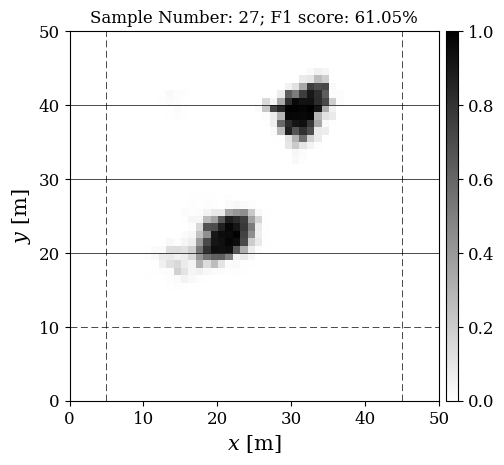

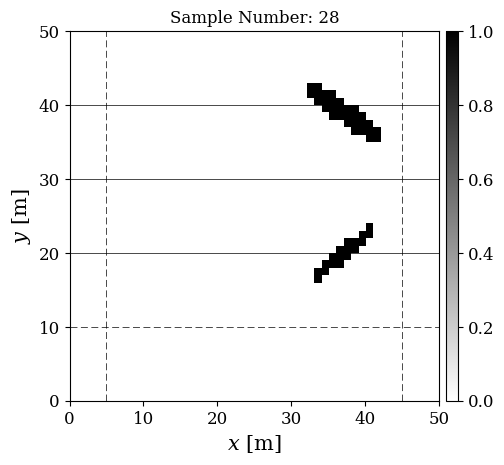

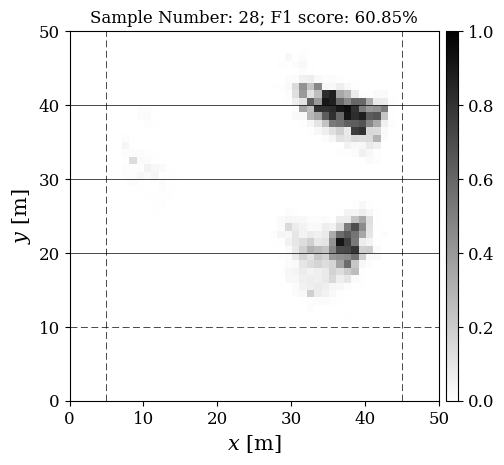

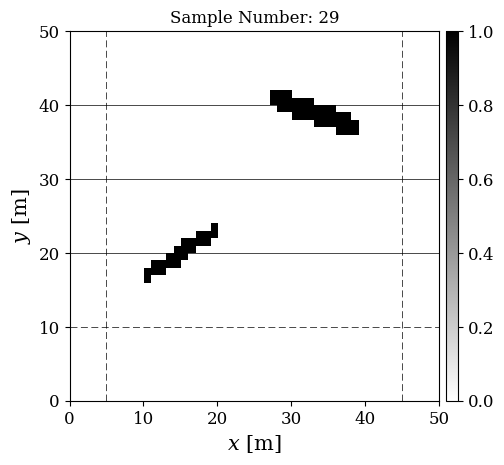

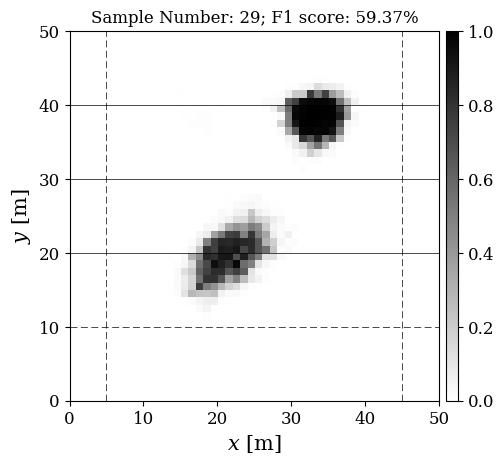

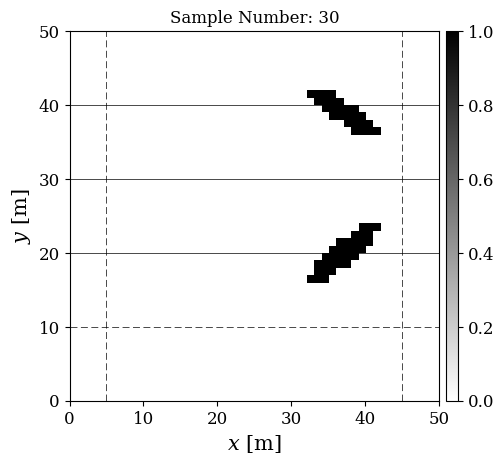

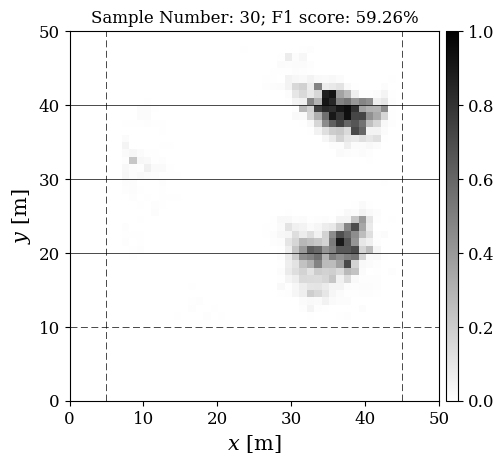

In [14]:
# Reshape the target and predicted data to a 50x50 grid
void_target_void_data = np.reshape(blind_void_data, (blind_void_data.shape[0], 50, 50))
void_predicted_void_data_probabilistic = np.reshape(void_predicted_void_data_probabilistic, (void_predicted_void_data_probabilistic.shape[0], 50, 50))

# Plot the void prediction
plot_void(void_target_void_data, void_predicted_void_data_probabilistic, prediction_results_directory, f1_score)